## Tempe Logistic and Poisson Regression (Classification Proof of Concept)
###### Code by Drew Gobbi - 11/30/19

### Import Packages and Data Cleaning

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads

In [2]:
#tempe ems 
eurl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Opioid_Calls/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
tempems = gpd.read_file(eurl)
tempems.to_csv('tempems.csv')

In [3]:
tempems.head()

,OBJECTID,Incident_Date,Weekday,Weekday_Sort,Month,Month_Sort,Year,Opioid_Use,Narcan_Given,Age,Patient_Gender,Patient_ASU,Patient_Veteran,Patient_Homeless,Latitude_Random,Longitude_Random,Spec_Pop,Notes,Time_of_Day,geometry
0,1,1483401600000,Tuesday,(3) Tuesday,January,(01) January,2017,Yes,NULL,40 to 44,Female,No,No,No,33.4196,-111.8904,None,None,Morning,POINT (-111.89040 33.41960)
1,2,1483920000000,Monday,(2) Monday,January,(01) January,2017,Unknown,Yes,40 to 44,Male,No,No,No,33.4127,-111.9505,None,None,Overnight,POINT (-111.95050 33.41270)
2,3,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,20 to 24,Male,No,No,Yes,33.3971,-111.9249,Homeless,None,Overnight,POINT (-111.92490 33.39710)
3,4,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,20 to 24,Male,No,No,Yes,33.4297,-111.9334,Homeless,None,Morning,POINT (-111.93340 33.42970)
4,5,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,70 to 74,Male,No,No,No,33.3681,-111.9014,None,None,Afternoon,POINT (-111.90140 33.36810)


In [4]:
tempems.dtypes

OBJECTID               int64
Incident_Date          int64
Weekday               object
Weekday_Sort          object
Month                 object
Month_Sort            object
Year                   int64
Opioid_Use            object
Narcan_Given          object
Age                   object
Patient_Gender        object
Patient_ASU           object
Patient_Veteran       object
Patient_Homeless      object
Latitude_Random      float64
Longitude_Random     float64
Spec_Pop              object
Notes                 object
Time_of_Day           object
geometry            geometry
dtype: object

In [5]:
tempems = tempems[tempems['Opioid_Use'] == 'Yes']

In [6]:
#city planning data
tempe = gpd.read_file("https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Map/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=")

In [7]:
tempe.head()

,OBJECTID,TempeTracts_STATEFP,TempeTracts_COUNTYFP,TempeTracts_TRACTCE,TempeTracts_GEOID,TempeTracts_NAME,TempeTracts_NAMELSAD,TempeTracts_MTFCC,TempeTracts_FUNCSTAT,TempeTracts_ALAND,...,pdb2018trv4_us_csv_pct_Vacants_,pdb2018trv4_us_csv_pct_Deletes_,pdb2018trv4_us_csv_pct_Census_U,pdb2018trv4_us_csv_pct_Mailback,pdb2018trv4_us_csv_pct_FRST_FRM,pdb2018trv4_us_csv_pct_RPLCMNT_,pdb2018trv4_us_csv_pct_BILQ_Mai,Shape__Area,Shape__Length,geometry
0,1,04,013,318800,04013318800,3188,Census Tract 3188,G5020,S,2569382,...,2.84,0,21.21,75.95,40.84,8.94,NaN,2.770706e+07,21462.867389,"POLYGON ((-111.96132 33.43719, -111.96132 33.4..."
1,2,04,013,319101,04013319101,3191.01,Census Tract 3191.01,G5020,S,330646,...,1.94,0,24.12,73.94,32.04,8.81,NaN,3.558325e+06,8618.283373,"POLYGON ((-111.92629 33.41915, -111.92611 33.4..."
2,3,04,013,318900,04013318900,3189,Census Tract 3189,G5020,S,2589083,...,3.04,0,9.56,87.41,58.33,6.86,NaN,2.786309e+07,21120.878745,"POLYGON ((-111.96090 33.42195, -111.95857 33.4..."
3,4,04,013,319000,04013319000,3190,Census Tract 3190,G5020,S,2588739,...,14.36,0,9.11,76.53,49.79,5.07,NaN,2.785941e+07,21103.097728,"POLYGON ((-111.94358 33.41505, -111.94357 33.4..."
4,5,04,013,319403,04013319403,3194.03,Census Tract 3194.03,G5020,S,2657428,...,5.68,0,4.26,90.06,66.37,0.00,NaN,2.869570e+07,21428.155647,"POLYGON ((-111.90912 33.39411, -111.90912 33.3..."


In [8]:
tempe.to_csv('tempe.csv')

In [9]:
tempems.shape

(745, 20)

In [10]:
tempems['Month'] = tempems['Month'].apply(lambda x: strptime(x,'%B').tm_mon)
tempems["date"] = tempems["Year"].map(str) + '-' + tempems["Month"].map(str)
tempems["date"] = pd.to_datetime(tempems["date"])

In [11]:
tempe_tract = pd.DataFrame()
for i in range(len(tempe)):
    df = tempems[tempems.within(tempe.loc[i,'geometry'])]
    df['tract'] = tempe.loc[i,'TempeTracts_NAME']
    tempe_tract = pd.concat([tempe_tract, df], axis=0)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
tempe_tract

,OBJECTID,Incident_Date,Weekday,Weekday_Sort,Month,Month_Sort,Year,Opioid_Use,Narcan_Given,Age,...,Patient_Veteran,Patient_Homeless,Latitude_Random,Longitude_Random,Spec_Pop,Notes,Time_of_Day,geometry,date,tract
28,29,1485734400000,Monday,(2) Monday,1,(01) January,2017,Yes,Yes,25 to 29,...,Yes,No,33.4279,-111.9591,Veteran,None,Evening,POINT (-111.95910 33.42790),2017-01-01,3188
97,98,1491177600000,Monday,(2) Monday,4,(04) April,2017,Yes,NULL,15 to 19,...,Yes,Yes,33.4338,-111.9449,Veteran/Homeless,None,Overnight,POINT (-111.94490 33.43380),2017-04-01,3188
110,111,1491868800000,Tuesday,(3) Tuesday,4,(04) April,2017,Yes,NULL,20 to 24,...,Unknown,No,33.4271,-111.9495,None,None,Morning,POINT (-111.94950 33.42710),2017-04-01,3188
166,167,1495238400000,Saturday,(7) Saturday,5,(05) May,2017,Yes,Yes,25 to 29,...,Unknown,No,33.4288,-111.9567,None,None,Morning,POINT (-111.95670 33.42880),2017-05-01,3188
191,192,1496707200000,Tuesday,(3) Tuesday,6,(06) June,2017,Yes,NULL,55 to 59,...,Unknown,No,33.4316,-111.9480,None,None,Morning,POINT (-111.94800 33.43160),2017-06-01,3188
215,216,1498521600000,Tuesday,(3) Tuesday,6,(06) June,2017,Yes,NULL,25 to 29,...,No,No,33.4314,-111.9504,None,None,Afternoon,POINT (-111.95040 33.43140),2017-06-01,3188
253,254,1500768000000,Sunday,(1) Sunday,7,(07) July,2017,Yes,NULL,30 to 34,...,No,No,33.4230,-111.9442,None,None,Overnight,POINT (-111.94420 33.42300),2017-07-01,3188
278,279,1501891200000,Saturday,(7) Saturday,8,(08) August,2017,Yes,Yes,25 to 29,...,Unknown,Unknown,33.4255,-111.9559,None,None,Evening,POINT (-111.95590 33.42550),2017-08-01,3188
283,284,1502668800000,Monday,(2) Monday,8,(08) August,2017,Yes,NULL,25 to 29,...,No,No,33.4272,-111.9542,None,None,Afternoon,POINT (-111.95420 33.42720),2017-08-01,3188
384,385,1510531200000,Monday,(2) Monday,11,(11) November,2017,Yes,Yes,20 to 24,...,Yes,No,33.4241,-111.9532,Veteran,None,Afternoon,POINT (-111.95320 33.42410),2017-11-01,3188


In [13]:
tempe_tract = tempe_tract.merge(tempe, left_on='tract', right_on='TempeTracts_NAME')

In [14]:
tempe_tract.drop('geometry_y', inplace=True, axis=1)

In [15]:
tempe_tract.rename(columns={'geometry_x':'geometry'}, inplace=True)
tempe_tract = gpd.GeoDataFrame(tempe_tract, geometry=tempe_tract.geometry)

In [16]:
mt = tempe_tract.groupby([tempe_tract['date'].dt.year.rename('year'), tempe_tract['date'].dt.month.rename('month'), 
                          tempe_tract['tract']]).agg({'count'})
mt = mt['Opioid_Use']
mt.reset_index(inplace=True)

mt.rename(columns={'count': 'ems_call'}, inplace=True)
tempe_tract['year'] = tempe_tract['date'].dt.year
tempe_tract['month'] = tempe_tract['date'].dt.month

tempe_tract = mt.merge(tempe_tract, on=['year', 'month', 'tract'])

In [17]:
tempe_tract.shape

(675, 496)

In [18]:
os.getcwd()

'/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot'

In [19]:
tempe_fac = pd.read_csv('TEMPEcntMedicalFacilitiesWithin2milesByTract.csv')

In [20]:
tempe_fac.dtypes

Unnamed: 0                         int64
TempeTracts_Name                 float64
HospitalsGeneralCount2mi           int64
HospitalsPsychCount2mi             int64
SurgicalCentersCount2mi            int64
UrgentCareCount2mi                 int64
WomensClinicsCount2mi              int64
PainManagementCount2mi             int64
PhysicalTherapyCount2mi            int64
MentalFacilitiesCount2mi           int64
SubstanceAbuseCount2mi             int64
OtherMedicalFacilitesCount2mi      int64
NursingAssistedLiveCount2mi        int64
HospiceCount2mi                    int64
ChildFacilitiesCount2mi            int64
PharmCount2mi                      int64
DrugDropCount2mi                   int64
NaloxoneDistribCount2mi            int64
geometry                          object
dtype: object

In [21]:
tempe_tract.TempeTracts_NAME = tempe_tract.TempeTracts_NAME.astype(float)

In [22]:
df = tempe_tract.merge(tempe_fac, left_on='TempeTracts_NAME', right_on='TempeTracts_Name')

In [23]:
df.drop('geometry_y', inplace=True, axis=1)

In [24]:
df['year_month'] = df['year'] + df['month']/100

In [25]:
df['year_month'].head()

0    2017.01
1    2017.01
2    2017.01
3    2017.02
4    2017.02
Name: year_month, dtype: float64

In [26]:
df['ems_flag'] = 0 
for i in range(len(df)):
    if df['ems_call'][i] >np.median(df['ems_call']):
        df['ems_flag'][i] =1

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [27]:
a = ['Shape__Area', 'Shape__Length', 'year', 'month', 'Unnamed: 0', 'OBJECTID_x', 'Incident_Date', 'Weekday',
         'Weekday_Sort', 'Month', 'Month_Sort', 'Year', 'Opioid_Use', 'Latitude_Random', 'Longitude_Random',
         'Spec_Pop', 'Notes', 'Time_of_Day', 'geometry_x', 'date', 'tract', 'OBJECTID_y', 'TempeTracts_STATEFP',
         'TempeTracts_COUNTYFP', 'TempeTracts_TRACTCE', 'TempeTracts_GEOID', 'TempeTracts_NAMELSAD',
         'TempeTracts_MTFCC', 'TempeTracts_FUNCSTAT', 'TempeTracts_ALAND', 'TempeTracts_AWATER', 'TempeTracts_INTPTLAT',
    'TempeTracts_INTPTLON', 'TempeTracts_TractNo', 'TempeTracts_GeoTrack']





In [28]:
df.drop(columns=a, inplace=True, axis=1)

### Logit

In [29]:
df.ems_flag.value_counts()

0    492
1    183
Name: ems_flag, dtype: int64

In [30]:
X = pd.get_dummies(df, drop_first=True)

In [31]:
b = ['Patient_Gender_NULL', 'Patient_Gender_Unknown (Unable to Determine)', 'Patient_ASU_Unknown',
    'Patient_Veteran_Unknown', 'Patient_Homeless_Unknown', 'pdb2018trv4_us_csv_GIDTR', 'pdb2018trv4_us_csv_State',
     'pdb2018trv4_us_csv_County', 'pdb2018trv4_us_csv_TRACTCE']

In [32]:
X.drop(columns=b, inplace=True, axis=1)

In [33]:
var = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 
'pdb2018trv4_us_csv_pct_Males_AC',
'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_25_4',
'pdb2018trv4_us_csv_pct_College_',
       'ems_flag']


In [34]:
fac = ['HospitalsGeneralCount2mi',
'HospitalsPsychCount2mi',
'SurgicalCentersCount2mi',
'UrgentCareCount2mi',
'WomensClinicsCount2mi',
'PainManagementCount2mi',
'PhysicalTherapyCount2mi',
'MentalFacilitiesCount2mi',
'SubstanceAbuseCount2mi',
'OtherMedicalFacilitesCount2mi',
'NursingAssistedLiveCount2mi',
'HospiceCount2mi',
'ChildFacilitiesCount2mi',
'PharmCount2mi',
'DrugDropCount2mi',
'NaloxoneDistribCount2mi',
'ems_flag']

In [35]:
X1 = X.filter(var)
X1.drop_duplicates(inplace=True)

In [36]:
y = X1.ems_flag
X1.drop(columns='ems_flag', inplace=True)

In [37]:
#just regressors 
res = sm.Logit(y, X1).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.557413
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                   50
Model:                          Logit   Df Residuals:                       45
Method:                           MLE   Df Model:                            4
Date:                Wed, 04 Dec 2019   Pseudo R-squ.:                 0.05994
Time:                        18:42:16   Log-Likelihood:                -27.871
converged:                       True   LL-Null:                       -29.648
                                        LLR p-value:                    0.4697
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_ -1.503e-05   2.66e-05     -0.566      0.572   -6.71e-05     3.7e-05
pdb2018trv4_us_csv_pct_Males_AC     0.0609      0.072      0.842      0.400      -0.081       0.203
pdb2018trv4_us_csv_pct_Pop_18_2     0.0040      0.032      0.125      0.900      -0.058       0.066
pdb2018trv4_us_csv_pct_Pop_25_4    -0.0751      0.076     -0.987      0.324      -0.224       0.074
pdb2018trv4_us_csv_pct_College_    -0.0337      0.048     -0.704      0.481      -0.127       0.060
===================================================================================================
"""

In [38]:
np.exp(res.params)

pdb2018trv4_us_csv_Med_HHD_Inc_    0.999985
pdb2018trv4_us_csv_pct_Males_AC    1.062832
pdb2018trv4_us_csv_pct_Pop_18_2    1.003989
pdb2018trv4_us_csv_pct_Pop_25_4    0.927687
pdb2018trv4_us_csv_pct_College_    0.966894
dtype: float64

In [39]:
X2 = X.filter(fac)

In [40]:
X2.drop_duplicates(inplace=True)
y = X2.ems_flag
X2.drop(columns='ems_flag', inplace=True)

In [41]:
#just facilities 
res = sm.Logit(y, X2).fit()
res.summary()

         Current function value: 0.486247
         Iterations: 35


/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                   50
Model:                          Logit   Df Residuals:                       34
Method:                           MLE   Df Model:                           15
Date:                Wed, 04 Dec 2019   Pseudo R-squ.:                  0.1800
Time:                        18:42:16   Log-Likelihood:                -24.312
converged:                      False   LL-Null:                       -29.648
                                        LLR p-value:                    0.7756
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsGeneralCount2mi          2.2643      1.879      1.205      0.228      -1.418       5.946
HospitalsPsychCount2mi            0.4023      2.118      0.190      0.849      -3.748       4.553
SurgicalCentersCount2mi           2.2177      1.798      1.233      0.217      -1.307       5.742
UrgentCareCount2mi               -0.2530      1.331     -0.190      0.849      -2.862       2.356
WomensClinicsCount2mi           -19.8599   8185.153     -0.002      0.998   -1.61e+04     1.6e+04
PainManagementCount2mi           -4.8749      3.114     -1.565      0.117     -10.978       1.229
PhysicalTherapyCount2mi          -0.5939      1.185     -0.501      0.616      -2.917       1.729
MentalFacilitiesCount2mi          1.3796      1.441      0.957      0.338      -1.445       4.205
SubstanceAbuseCount2mi           -1.7189      1.646     -1.044      0.296      -4.945       1.507
OtherMedicalFacilitesCount2mi    -0.0780      0.354     -0.220      0.826      -0.772       0.616
NursingAssistedLiveCount2mi      -0.1619      0.213     -0.761      0.446      -0.579       0.255
HospiceCount2mi                  -1.0386      1.342     -0.774      0.439      -3.669       1.591
ChildFacilitiesCount2mi          -0.5305      0.525     -1.010      0.313      -1.560       0.499
PharmCount2mi                     0.0149      0.225      0.066      0.947      -0.426       0.456
DrugDropCount2mi                  1.5063      0.996      1.512      0.131      -0.447       3.459
NaloxoneDistribCount2mi          -0.5789      0.563     -1.028      0.304      -1.682       0.524
=================================================================================================
"""

In [42]:
v = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 
'pdb2018trv4_us_csv_pct_Males_AC',
'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_25_4',
'pdb2018trv4_us_csv_pct_College_',
'ems_flag', 
'HospitalsGeneralCount2mi',
'HospitalsPsychCount2mi',
'SurgicalCentersCount2mi',
'UrgentCareCount2mi',
'WomensClinicsCount2mi',
'PainManagementCount2mi',
'PhysicalTherapyCount2mi',
'MentalFacilitiesCount2mi',
'SubstanceAbuseCount2mi',
'OtherMedicalFacilitesCount2mi',
'NursingAssistedLiveCount2mi',
'HospiceCount2mi',
'ChildFacilitiesCount2mi',
'PharmCount2mi',
'DrugDropCount2mi',
'NaloxoneDistribCount2mi',]


In [43]:
Xall = X.filter(v)
Xall.drop_duplicates(inplace=True)
y = Xall.ems_flag
Xall.drop(columns='ems_flag', inplace=True)

In [110]:
#everything
res = sm.Logit(y, Xall).fit()
res.summary()

         Current function value: 0.447608
         Iterations: 35


/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                   50
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                           20
Date:                Wed, 04 Dec 2019   Pseudo R-squ.:                  0.2451
Time:                        21:30:10   Log-Likelihood:                -22.380
converged:                      False   LL-Null:                       -29.648
                                        LLR p-value:                    0.8024
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_   -2.7e-05   4.73e-05     -0.571      0.568      -0.000    6.56e-05
pdb2018trv4_us_csv_pct_Males_AC     0.1146      0.149      0.769      0.442      -0.177       0.407
pdb2018trv4_us_csv_pct_Pop_18_2    -0.0197      0.073     -0.268      0.788      -0.163       0.124
pdb2018trv4_us_csv_pct_Pop_25_4    -0.2078      0.213     -0.975      0.329      -0.626       0.210
pdb2018trv4_us_csv_pct_College_    -0.1129      0.108     -1.047      0.295      -0.324       0.098
HospitalsGeneralCount2mi            2.0986      2.518      0.834      0.405      -2.836       7.033
HospitalsPsychCount2mi              3.1452      4.151      0.758      0.449      -4.991      11.282
SurgicalCentersCount2mi             3.3117      2.675      1.238      0.216      -1.932       8.555
UrgentCareCount2mi                 -0.8779      2.125     -0.413      0.680      -5.044       3.288
WomensClinicsCount2mi             -20.8301   8515.308     -0.002      0.998   -1.67e+04    1.67e+04
PainManagementCount2mi             -6.8907      5.446     -1.265      0.206     -17.566       3.784
PhysicalTherapyCount2mi            -1.2898      1.741     -0.741      0.459      -4.703       2.123
MentalFacilitiesCount2mi            3.0082      2.887      1.042      0.297      -2.651       8.667
SubstanceAbuseCount2mi             -3.2106      3.236     -0.992      0.321      -9.552       3.131
OtherMedicalFacilitesCount2mi       0.2305      0.598      0.386      0.700      -0.941       1.402
NursingAssistedLiveCount2mi         0.0236      0.279      0.084      0.933      -0.523       0.570
HospiceCount2mi                    -1.2748      2.153     -0.592      0.554      -5.495       2.945
ChildFacilitiesCount2mi            -1.1288      0.927     -1.218      0.223      -2.945       0.688
PharmCount2mi                       0.2371      0.412      0.575      0.565      -0.571       1.045
DrugDropCount2mi                    2.6609      1.822      1.461      0.144      -0.910       6.231
NaloxoneDistribCount2mi            -1.0814      0.975     -1.110      0.267      -2.992       0.829
===================================================================================================
"""

In [111]:
np.exp(res.params)

pdb2018trv4_us_csv_Med_HHD_Inc_    9.999730e-01
pdb2018trv4_us_csv_pct_Males_AC    1.121439e+00
pdb2018trv4_us_csv_pct_Pop_18_2    9.805197e-01
pdb2018trv4_us_csv_pct_Pop_25_4    8.123550e-01
pdb2018trv4_us_csv_pct_College_    8.932096e-01
HospitalsGeneralCount2mi           8.154972e+00
HospitalsPsychCount2mi             2.322513e+01
SurgicalCentersCount2mi            2.743215e+01
UrgentCareCount2mi                 4.156586e-01
WomensClinicsCount2mi              8.987182e-10
PainManagementCount2mi             1.017204e-03
PhysicalTherapyCount2mi            2.753196e-01
MentalFacilitiesCount2mi           2.025058e+01
SubstanceAbuseCount2mi             4.033323e-02
OtherMedicalFacilitesCount2mi      1.259216e+00
NursingAssistedLiveCount2mi        1.023854e+00
HospiceCount2mi                    2.794823e-01
ChildFacilitiesCount2mi            3.234243e-01
PharmCount2mi                      1.267515e+00
DrugDropCount2mi                   1.430852e+01
NaloxoneDistribCount2mi            3.391

#### Discussion 
Results of all three experiments show a pseudo R2 below 10%, suggesting that our logit model does not explain a sufficient amount of the  variation to be explanatory.

### Poisson Regression

In [45]:
v = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 
'pdb2018trv4_us_csv_pct_Males_AC',
'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_25_4',
'pdb2018trv4_us_csv_pct_College_',
'ems_call',
'year_month',
'TempeTracts_NAME', 
'HospitalsGeneralCount2mi',
'HospitalsPsychCount2mi',
'SurgicalCentersCount2mi',
'UrgentCareCount2mi',
'WomensClinicsCount2mi',
'PainManagementCount2mi',
'PhysicalTherapyCount2mi',
'MentalFacilitiesCount2mi',
'SubstanceAbuseCount2mi',
'OtherMedicalFacilitesCount2mi',
'NursingAssistedLiveCount2mi',
'HospiceCount2mi',
'ChildFacilitiesCount2mi',
'PharmCount2mi',
'DrugDropCount2mi',
'NaloxoneDistribCount2mi',]

In [46]:
df = X.filter(v)

In [47]:
df.drop_duplicates(inplace=True)

In [48]:
len(df)

440

In [49]:
df['ymt'] = df.year_month.astype(str) + '__' + df['TempeTracts_NAME'].astype(str)

In [50]:
df.set_index('ymt', inplace=True)

In [51]:
df.drop(columns=['year_month', 'TempeTracts_NAME'], inplace=True)

In [52]:
#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=344
Testing data set length=96


In [53]:
y_train, X_train = df_train.ems_call, df_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = df_test.ems_call, df_test
X_test.drop(columns='ems_call', inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [54]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                  344
Model:                            GLM   Df Residuals:                      323
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -443.24
Date:                Wed, 04 Dec 2019   Deviance:                       103.35
Time:                        18:42:17   Pearson chi2:                     116.
No. Iterations:                     4   Covariance Type:             nonrobust
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_   5.13e-06   5.45e-06      0.942      0.346   -5.54e-06    1.58e-05
pdb2018trv4_us_csv_pct_Males_AC     0.0261      0.015      1.762      0.078      -0.003       0.055
pdb2018trv4_us_csv_pct_Pop_18_2     0.0011      0.007      0.147      0.883      -0.014       0.016
pdb2018trv4_us_csv_pct_Pop_25_4    -0.0243      0.016     -1.526      0.127      -0.056       0.007
pdb2018trv4_us_csv_pct_College_    -0.0229      0.008     -2.948      0.003      -0.038      -0.008
HospitalsGeneralCount2mi           -0.0035      0.194     -0.018      0.985      -0.384       0.377
HospitalsPsychCount2mi             -0.0681      0.317     -0.215      0.830      -0.690       0.554
SurgicalCentersCount2mi            -0.0566      0.208     -0.272      0.785      -0.464       0.351
UrgentCareCount2mi                 -0.0687      0.202     -0.341      0.733      -0.464       0.327
WomensClinicsCount2mi              -0.7910      0.804     -0.984      0.325      -2.367       0.785
PainManagementCount2mi             -0.0667      0.267     -0.250      0.802      -0.590       0.456
PhysicalTherapyCount2mi             0.0958      0.177      0.542      0.588      -0.250       0.442
MentalFacilitiesCount2mi            0.0883      0.145      0.610      0.542      -0.196       0.372
SubstanceAbuseCount2mi             -0.1007      0.140     -0.719      0.472      -0.375       0.174
OtherMedicalFacilitesCount2mi      -0.0748      0.046     -1.643      0.100      -0.164       0.014
NursingAssistedLiveCount2mi         0.0303      0.034      0.885      0.376      -0.037       0.097
HospiceCount2mi                    -0.0433      0.173     -0.251      0.802      -0.382       0.295
ChildFacilitiesCount2mi            -0.0399      0.054     -0.740      0.459      -0.146       0.066
PharmCount2mi                       0.0721      0.040      1.817      0.069      -0.006       0.150
DrugDropCount2mi                    0.2751      0.089      3.092      0.002       0.101       0.449
NaloxoneDistribCount2mi            -0.1463      0.072     -2.037      0.042      -0.287      -0.006
===================================================================================================
"""

In [55]:
poisson_predictions = res.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
ymt,,,,
2017.03__3184.0,2.594985,0.31291,2.048778,3.286812
2017.05__3184.0,2.594985,0.31291,2.048778,3.286812
2017.08__3184.0,2.594985,0.31291,2.048778,3.286812
2018.05__3184.0,2.594985,0.31291,2.048778,3.286812
2019.08__3184.0,2.594985,0.31291,2.048778,3.286812


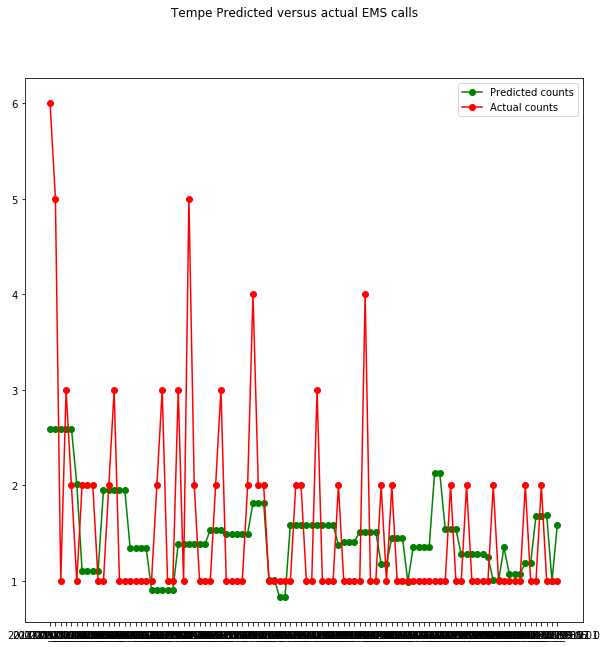

<Figure size 432x288 with 0 Axes>

In [56]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.suptitle('Tempe Predicted versus actual EMS calls')
predicted, = plt.plot(predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('Tempe_EMS_poisson')

#### Add Fixed Effects 

In [57]:
len(predictions_summary_frame['mean'])

96

In [58]:
len(y_test)

96

In [59]:
len(tempems)

745

In [60]:
df2 = X.filter(v)

In [61]:
df2.head()

,pdb2018trv4_us_csv_Med_HHD_Inc_,pdb2018trv4_us_csv_pct_Males_AC,pdb2018trv4_us_csv_pct_Pop_18_2,pdb2018trv4_us_csv_pct_Pop_25_4,pdb2018trv4_us_csv_pct_College_,ems_call,year_month,TempeTracts_NAME,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,...,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi
0,43300,51.36,28.65,33.12,27.02,3,2017.01,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
1,43300,51.36,28.65,33.12,27.02,3,2017.01,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
2,43300,51.36,28.65,33.12,27.02,3,2017.01,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
3,43300,51.36,28.65,33.12,27.02,5,2017.02,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
4,43300,51.36,28.65,33.12,27.02,5,2017.02,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5


In [62]:
df2.drop_duplicates(inplace=True)

In [63]:
df2['ymt'] = df2.year_month.astype(str) + '__' + df2['TempeTracts_NAME'].astype(str)
df2.set_index('ymt', inplace=True)

In [64]:
df2 = pd.get_dummies(df2, columns=['year_month', 'TempeTracts_NAME'], drop_first=True)

In [65]:
#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
mask = np.random.rand(len(df2)) < 0.8
df2_train = df2[mask]
df2_test = df2[~mask]
print('Training data set length='+str(len(df2_train)))
print('Testing data set length='+str(len(df2_test)))

Training data set length=364
Testing data set length=76


In [66]:
y_train, X_train = df2_train.ems_call, df2_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = df2_test.ems_call, df2_test
X_test.drop(columns='ems_call', inplace=True)

In [67]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                  364
Model:                            GLM   Df Residuals:                      297
Model Family:                 Poisson   Df Model:                           66
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -456.36
Date:                Wed, 04 Dec 2019   Deviance:                       90.172
Time:                        18:42:20   Pearson chi2:                     98.0
No. Iterations:                     4   Covariance Type:             nonrobust
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_  1.292e-05   7.12e-06      1.814      0.070   -1.04e-06    2.69e-05
pdb2018trv4_us_csv_pct_Males_AC     0.0041      0.016      0.252      0.801      -0.028       0.036
pdb2018trv4_us_csv_pct_Pop_18_2     0.0085      0.008      1.022      0.307      -0.008       0.025
pdb2018trv4_us_csv_pct_Pop_25_4     0.0033      0.017      0.190      0.849      -0.031       0.037
pdb2018trv4_us_csv_pct_College_    -0.0194      0.010     -2.033      0.042      -0.038      -0.001
HospitalsGeneralCount2mi            0.0276      0.137      0.201      0.841      -0.241       0.297
HospitalsPsychCount2mi              0.0115      0.226      0.051      0.960      -0.431       0.454
SurgicalCentersCount2mi            -0.0173      0.158     -0.110      0.913      -0.326       0.292
UrgentCareCount2mi                 -0.1462      0.167     -0.875      0.382      -0.474       0.181
WomensClinicsCount2mi              -0.1456      0.221     -0.659      0.510      -0.579       0.288
PainManagementCount2mi             -0.0811      0.175     -0.464      0.642      -0.423       0.261
PhysicalTherapyCount2mi             0.1099      0.161      0.681      0.496      -0.206       0.426
MentalFacilitiesCount2mi           -0.0427      0.161     -0.265      0.791      -0.359       0.273
SubstanceAbuseCount2mi              0.0499      0.124      0.404      0.686      -0.192       0.292
OtherMedicalFacilitesCount2mi      -0.0437      0.040     -1.098      0.272      -0.122       0.034
NursingAssistedLiveCount2mi        -0.0214      0.041     -0.523      0.601      -0.101       0.059
HospiceCount2mi                     0.1383      0.163      0.849      0.396      -0.181       0.457
ChildFacilitiesCount2mi            -0.0236      0.045     -0.529      0.597      -0.111       0.064
PharmCount2mi                       0.0163      0.034      0.475      0.635      -0.051       0.084
DrugDropCount2mi                    0.1877      0.086      2.181      0.029       0.019       0.356
NaloxoneDistribCount2mi            -0.0371      0.069     -0.540      0.589      -0.172       0.098
year_month_2017.02                  0.0351      0.358      0.098      0.922      -0.668       0.738
year_month_2017.03                  0.0860      0.368      0.234      0.815      -0.636       0.808
year_month_2017.04                  0.2641      0.338      0.782      0.434      -0.398       0.926
year_month_2017.05                  0.0155      0.350      0.044      0.965      -0.670       0.701
year_month_2017.06                 -0.0954      0.356     -0.268      0.789      -0.793       0.602
year_month_2017.07                  0.3979      0.337      1.180      0.238      -0.263       1.059
year_month_2017.08                 -0.2022      0.397     -0.510      0.610      -0.979       0.575
year_month_2017.09                 -0.2112      0.403     -0.5

In [68]:
poisson_predictions = res.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
ymt,,,,
2018.03__3184.0,2.856532,0.808209,1.640612,4.973619
2018.06__3184.0,2.654248,0.795029,1.475640,4.774222
2018.08__3184.0,2.388687,0.721807,1.321129,4.318900
2019.02__3184.0,2.130279,0.700012,1.118744,4.056412
2019.03__3184.0,2.195446,0.632701,1.248006,3.862148


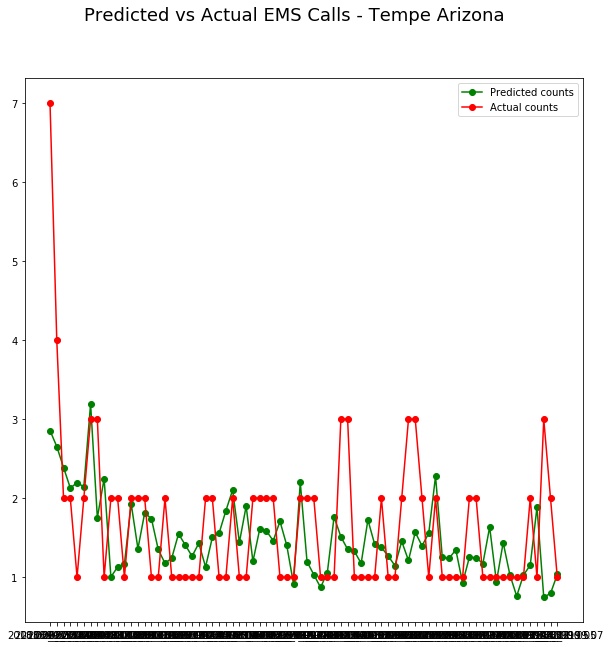

<Figure size 432x288 with 0 Axes>

In [109]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.suptitle('Predicted vs Actual EMS Calls - Tempe Arizona', size=18)
predicted, = plt.plot(predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('Tempe_EMS_Poisson_wFE')

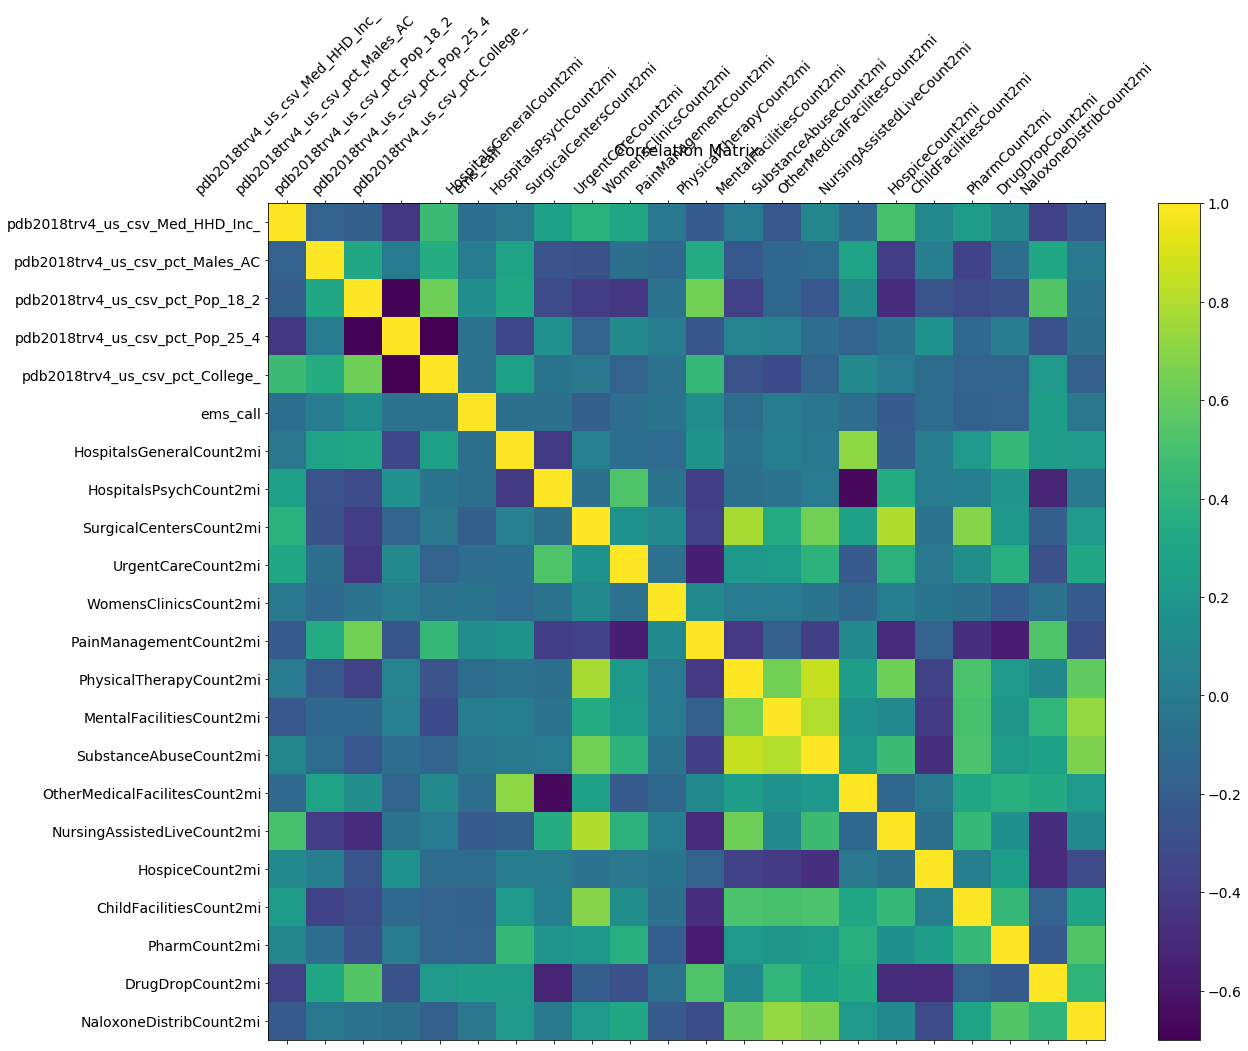

In [73]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [74]:
facilities = df.filter([''])

,pdb2018trv4_us_csv_Med_HHD_Inc_,pdb2018trv4_us_csv_pct_Males_AC,pdb2018trv4_us_csv_pct_Pop_18_2,pdb2018trv4_us_csv_pct_Pop_25_4,pdb2018trv4_us_csv_pct_College_,ems_call,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,...,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi
pdb2018trv4_us_csv_Med_HHD_Inc_,1.000000,-0.167747,-0.183494,-0.424034,0.467797,-0.079807,-0.017089,0.266731,0.387750,0.313028,...,-0.005019,-0.240294,0.077149,-0.121548,0.505353,0.100069,0.229128,0.081890,-0.373358,-0.227888
pdb2018trv4_us_csv_pct_Males_AC,-0.167747,1.000000,0.318799,0.004355,0.352165,0.018494,0.276410,-0.266559,-0.280073,-0.075794,...,-0.230520,-0.135115,-0.097303,0.281495,-0.392697,0.023764,-0.360833,-0.086445,0.321601,-0.015041
pdb2018trv4_us_csv_pct_Pop_18_2,-0.183494,0.318799,1.000000,-0.683883,0.621517,0.134348,0.320865,-0.306401,-0.389084,-0.431124,...,-0.373729,-0.134534,-0.239390,0.139030,-0.482583,-0.260033,-0.311455,-0.278313,0.543420,-0.055950
pdb2018trv4_us_csv_pct_Pop_25_4,-0.424034,0.004355,-0.683883,1.000000,-0.700794,-0.054822,-0.334106,0.159944,-0.142724,0.100574,...,0.058224,0.041556,-0.084905,-0.155444,-0.056945,0.175894,-0.117760,0.014190,-0.272000,-0.072023
pdb2018trv4_us_csv_pct_College_,0.467797,0.352165,0.621517,-0.700794,1.000000,-0.055565,0.266383,-0.048484,-0.018140,-0.158747,...,-0.265195,-0.317764,-0.148586,0.101617,-0.008277,-0.097748,-0.163365,-0.148471,0.215764,-0.179350
ems_call,-0.079807,0.018494,0.134348,-0.054822,-0.055565,1.000000,-0.070949,-0.074100,-0.186461,-0.085176,...,-0.100956,0.017484,-0.029791,-0.087443,-0.208814,-0.097138,-0.170895,-0.165553,0.248664,-0.026190
HospitalsGeneralCount2mi,-0.017089,0.276410,0.320865,-0.334106,0.266383,-0.070949,1.000000,-0.414618,0.043021,-0.078410,...,-0.058118,0.034869,-0.013263,0.710427,-0.189071,0.012073,0.215604,0.435138,0.239908,0.210269
HospitalsPsychCount2mi,0.266731,-0.266559,-0.306401,0.159944,-0.048484,-0.074100,-0.414618,1.000000,-0.071243,0.533694,...,-0.071876,-0.053205,-0.002987,-0.657105,0.351008,0.021567,0.035162,0.188290,-0.522590,-0.010932
SurgicalCentersCount2mi,0.387750,-0.280073,-0.389084,-0.142724,-0.018140,-0.186461,0.043021,-0.071243,1.000000,0.168153,...,0.777930,0.344005,0.635908,0.270836,0.794141,-0.053003,0.690439,0.205998,-0.184926,0.218598
UrgentCareCount2mi,0.313028,-0.075794,-0.431124,0.100574,-0.158747,-0.085176,-0.078410,0.533694,0.168153,1.000000,...,0.205043,0.227409,0.401975,-0.215441,0.393623,-0.020460,0.142437,0.366134,-0.277560,0.321276


In [77]:
facility = df.filter(['HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'ChildFacilitiesCount2mi', 'PharmCount2mi', 'DrugDropCount2mi',
       'NaloxoneDistribCount2mi'])

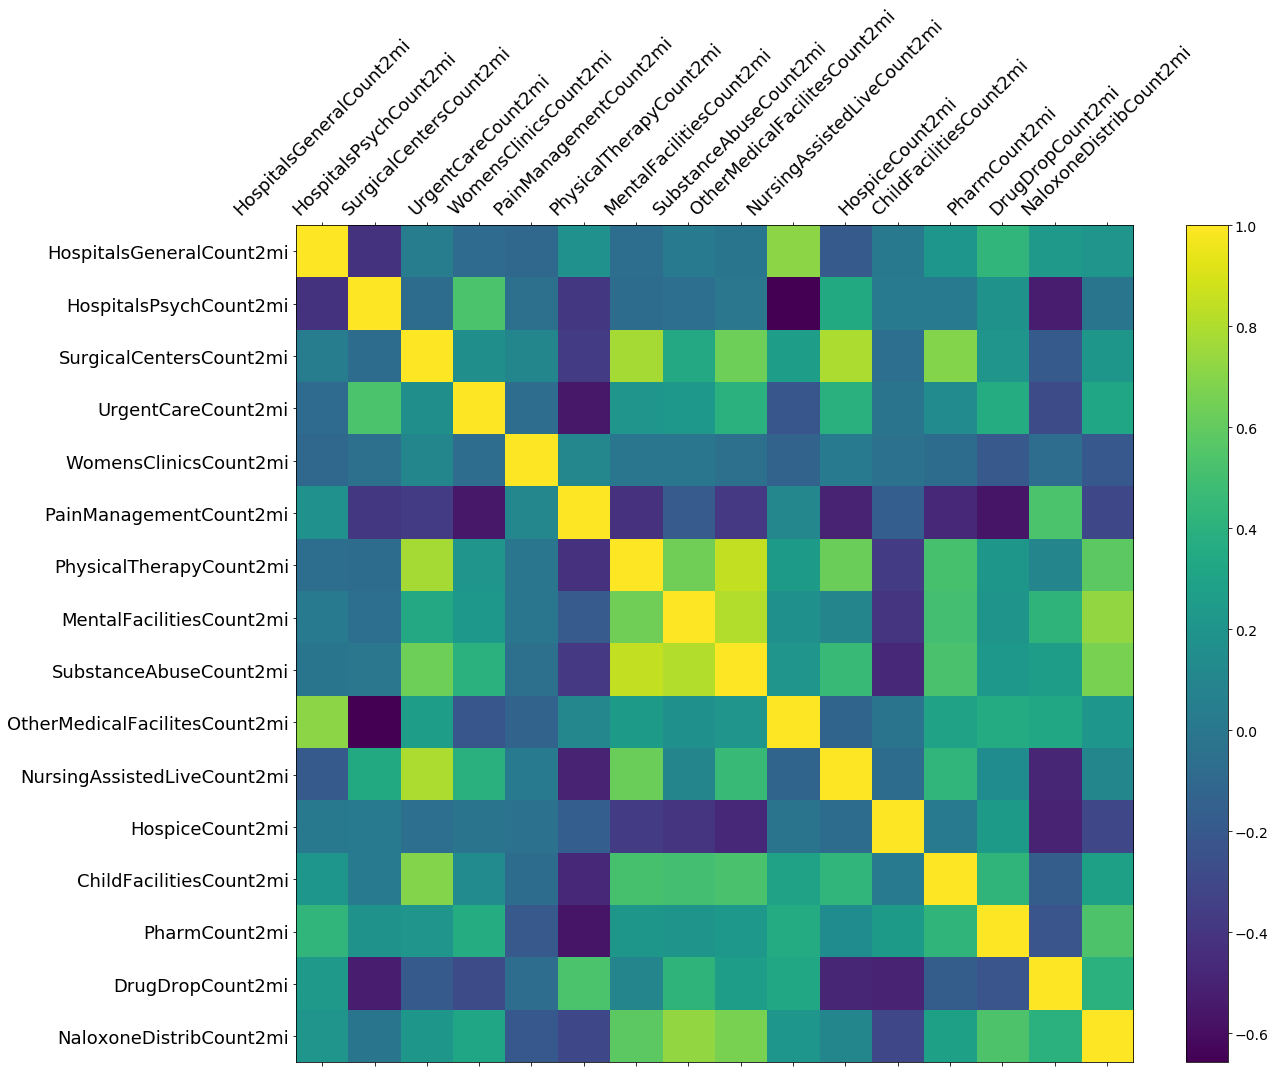

In [92]:
f = plt.figure(figsize=(19, 15))
plt.matshow(facility.corr(), fignum=f.number)
plt.xticks(range(facility.shape[1]), facility.columns, fontsize=18, rotation=45)
plt.yticks(range(facility.shape[1]), facility.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [88]:
acs = df.filter(['pdb2018trv4_us_csv_Med_HHD_Inc_', 'pdb2018trv4_us_csv_pct_Males_AC',
       'pdb2018trv4_us_csv_pct_Pop_18_2', 'pdb2018trv4_us_csv_pct_Pop_25_4',
       'pdb2018trv4_us_csv_pct_College_'])

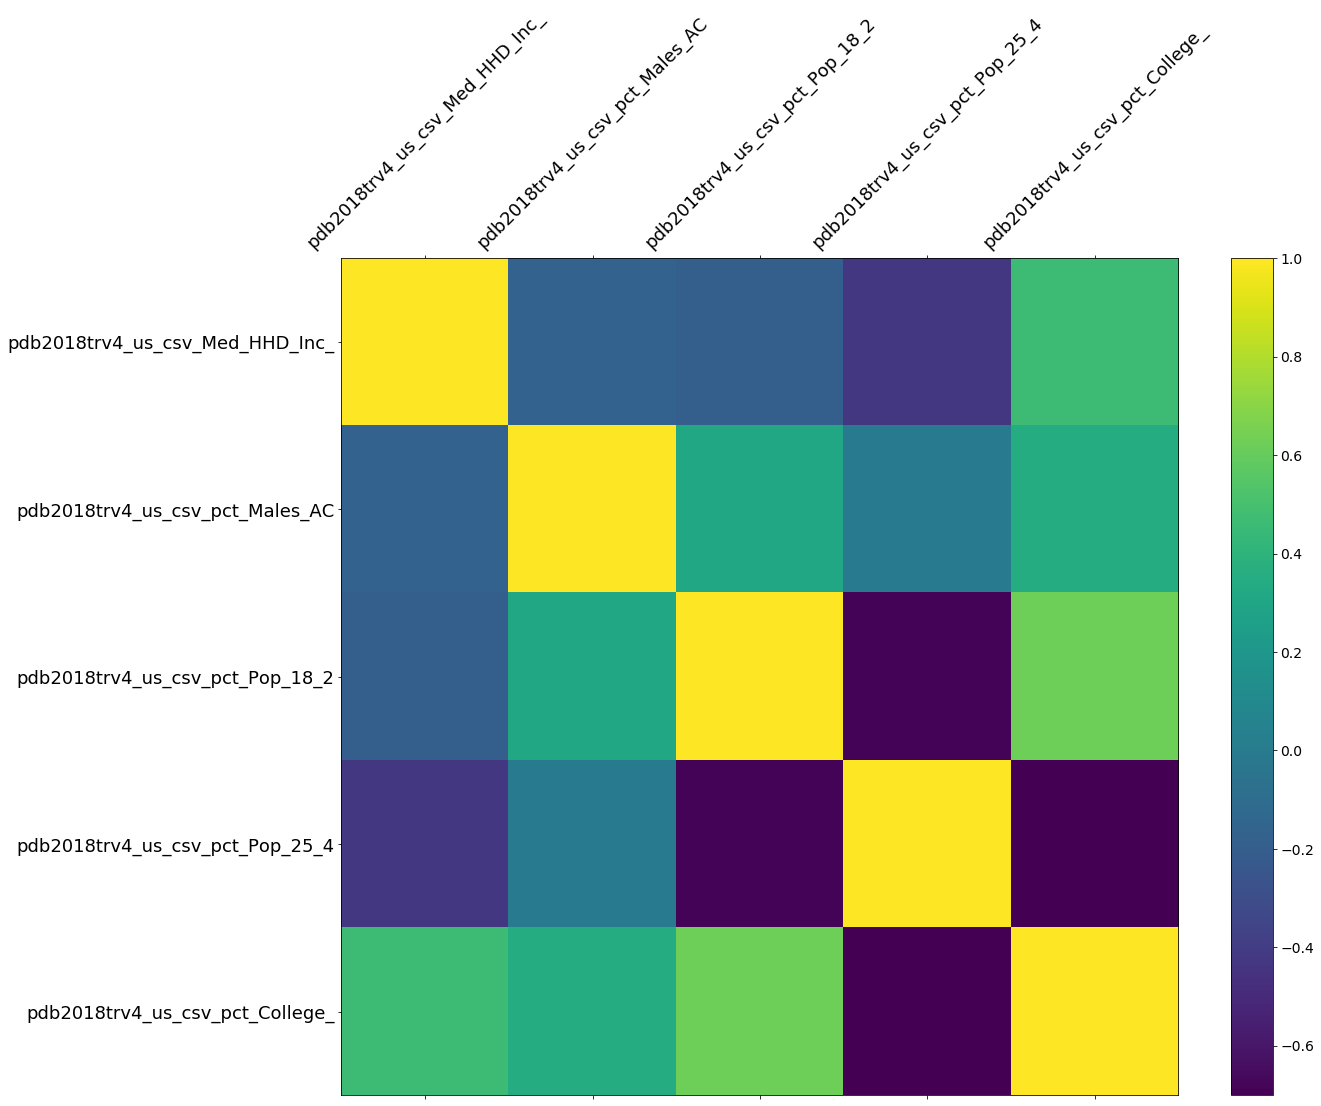

In [91]:
f = plt.figure(figsize=(19, 15))
plt.matshow(acs.corr(), fignum=f.number)
plt.xticks(range(acs.shape[1]), acs.columns, fontsize=18, rotation=45)
plt.yticks(range(acs.shape[1]), acs.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [87]:
df.columns

Index(['pdb2018trv4_us_csv_Med_HHD_Inc_', 'pdb2018trv4_us_csv_pct_Males_AC',
       'pdb2018trv4_us_csv_pct_Pop_18_2', 'pdb2018trv4_us_csv_pct_Pop_25_4',
       'pdb2018trv4_us_csv_pct_College_', 'ems_call',
       'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'ChildFacilitiesCount2mi', 'PharmCount2mi', 'DrugDropCount2mi',
       'NaloxoneDistribCount2mi'],
      dtype='object')

Text(0.5, 1.0, 'Histogram of Monthly EMS Calls by Census Tract, Tempe Arizona')

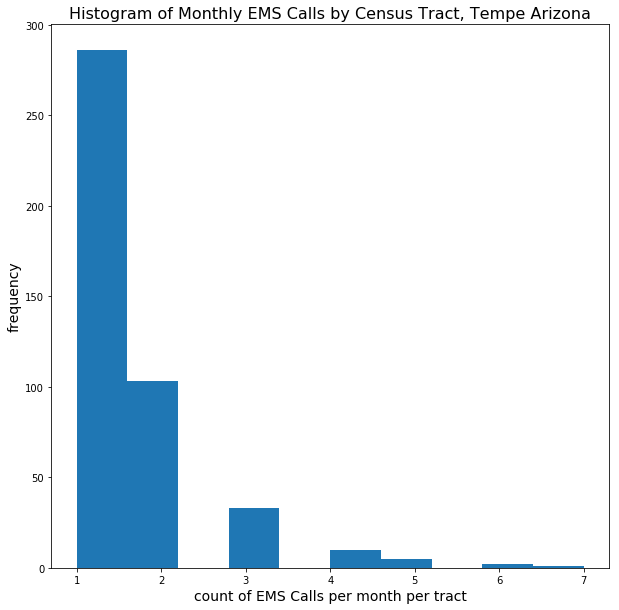

In [105]:
plt.figure(figsize=(10,10))
plt.hist(df.ems_call)
plt.xlabel('count of EMS Calls per month per tract', size=14)
plt.ylabel('frequency',size=14)
plt.title('Histogram of Monthly EMS Calls by Census Tract, Tempe Arizona', size=16)

In [97]:
df.index

Index(['2017.01__3184.0', '2017.02__3184.0', '2017.03__3184.0',
       '2017.04__3184.0', '2017.05__3184.0', '2017.06__3184.0',
       '2017.07__3184.0', '2017.08__3184.0', '2017.09__3184.0',
       '2017.1__3184.0',
       ...
       '2018.1__3199.07', '2017.08__3199.1', '2017.1__3199.1',
       '2017.11__3199.1', '2018.02__3199.1', '2017.09__3185.01',
       '2017.1__3185.01', '2018.02__3185.01', '2018.05__8101.0',
       '2019.02__8101.0'],
      dtype='object', name='ymt', length=440)

In [106]:
len(df2)

440

In [121]:
df3 = df2.corr()

In [132]:
corr = pd.DataFrame(df3['ems_call'])

In [141]:
corr[:22]

,ems_call
pdb2018trv4_us_csv_Med_HHD_Inc_,-0.079807
pdb2018trv4_us_csv_pct_Males_AC,0.018494
pdb2018trv4_us_csv_pct_Pop_18_2,0.134348
pdb2018trv4_us_csv_pct_Pop_25_4,-0.054822
pdb2018trv4_us_csv_pct_College_,-0.055565
ems_call,1.000000
HospitalsGeneralCount2mi,-0.070949
HospitalsPsychCount2mi,-0.074100
SurgicalCentersCount2mi,-0.186461
UrgentCareCount2mi,-0.085176


,0
0,<bound method DataFrame.corr of ...
